# 《人工神经网络理论、设计及应用》代码实践-第十章 深度神经网络
<hr>

## 本章需要安装的第三方包与软件

imageio

### 10.2 深度网络的网络类型和学习算法

#### Page208 10.2.1 DBN深度信念网

文件夹 '/home/renhj/ann_test/test3' 已创建。
当前工作目录已切换到 '/home/renhj/ann_test/test3'。
Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|███████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:21<00:00, 459kB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 93.3kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|███████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:04<00:00, 363kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.54MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

/home/renhj/ann_test/test3


梯度下降: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.19it/s]


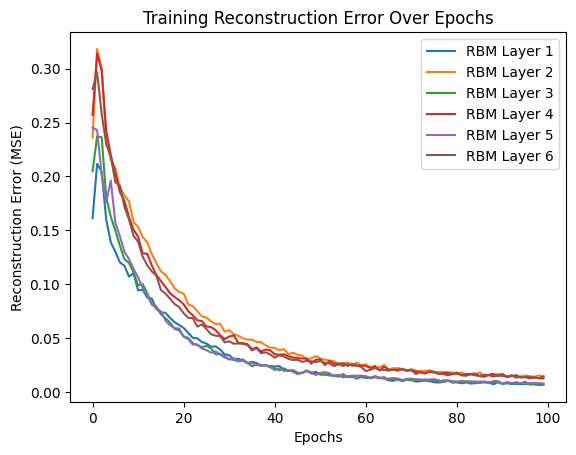

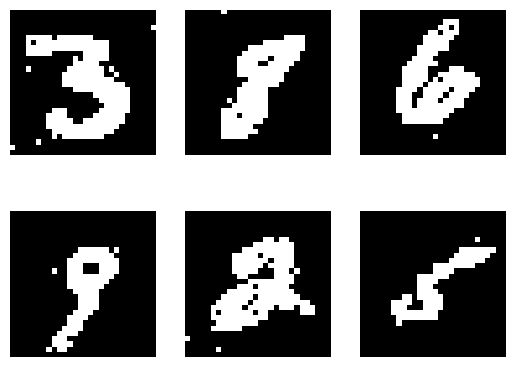

In [1]:
# DBN网络，用MNIST数据集训练，生成以下代码来自互联网文章

import numpy as np
from torchvision.datasets import MNIST
np.random.seed(2)
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from pathlib import Path

# 创建工作目录
def create_relative_path(folder_path):
    # 将路径中的 ~ 解析为用户的主目录
    expanded_path = os.path.expanduser(folder_path)
    
    # 将路径转换为Path对象，以便跨平台兼容
    path = Path(expanded_path)
    
    # 如果路径不存在，则创建多级目录
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
        print(f"文件夹 '{expanded_path}' 已创建。")
    else:
        print(f"文件夹 '{expanded_path}' 已存在，未进行覆盖。")
    
    # 切换工作目录到新创建的文件夹
    os.chdir(path)
    print(f"当前工作目录已切换到 '{path}'。")

# 示例：创建相对路径文件夹，支持 ~
work_path = "~/ann_test/test3"
create_relative_path(work_path)

class RBM():
    def __init__(self, x_layer, h_layer):
        self.x_layer = x_layer
        self.h_layer = h_layer
        self.w = np.random.normal(0, 0.1, size=(self.x_layer, self.h_layer))
        self.a = np.random.normal(0, 0.1, size=(self.h_layer, 1))
        self.b = np.random.normal(0, 0.1, size=(self.x_layer, 1))
        self.learning_rate = 0.1
        self.errors = []  # 记录每个epoch的误差

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_Ph_x(self, x):
        H = x @ self.w + self.a.T
        return self.sigmoid(H)

    def sigmoid_Px_h(self, h):
        H = (self.w @ h.T + self.b).T
        return self.sigmoid(H)

    def compute_reconstruction_error(self, x):
        P_h_given_x = self.sigmoid_Ph_x(x)
        h_sample = np.random.binomial(1, p=P_h_given_x, size=P_h_given_x.shape)
        P_x_given_h = self.sigmoid_Px_h(h_sample)
        reconstruction = np.random.binomial(1, p=P_x_given_h, size=P_x_given_h.shape)
        error = np.mean((x - reconstruction) ** 2)
        return error

    def train(self, x, K):
        for epoch in tqdm(range(100), desc="梯度下降"):
            x0 = x.copy()
            for _ in range(K):  # 吉布斯采样K次
                P_h_given_x = self.sigmoid_Ph_x(x0)
                h0 = np.random.binomial(1, p=P_h_given_x, size=(x.shape[0], self.h_layer))
                P_x_given_h = self.sigmoid_Px_h(h0)
                x0 = np.random.binomial(1, p=P_x_given_h, size=(x.shape[0], self.x_layer))

            true_h = self.sigmoid_Ph_x(x)
            x_sample_h = self.sigmoid_Ph_x(x0)

            w_GD = (x.T @ true_h - x0.T @ x_sample_h) / x.shape[0]
            a_GD = np.mean(true_h - x_sample_h, axis=0).reshape(-1, 1)
            b_GD = np.mean(x - x0, axis=0).reshape(-1, 1)

            self.w += self.learning_rate * w_GD
            self.a += self.learning_rate * a_GD
            self.b += self.learning_rate * b_GD

            # 在每个epoch结束时计算并记录误差
            error = self.compute_reconstruction_error(x)
            self.errors.append(error)

class DBN():
    def __init__(self, layer):
        self.layer = layer
        self.RBMS = []
        for i in range(len(layer) - 1):
            rbm = RBM(layer[i], layer[i+1])
            self.RBMS.append(rbm)

    def train(self, data, k):
        for rbm in self.RBMS:
            rbm.train(data, k)
            p = rbm.sigmoid_Ph_x(data)
            data = np.random.binomial(1, p=p, size=p.shape)

    def predict(self, x):
        for rbm in self.RBMS:
            p = rbm.sigmoid_Ph_x(x)
            x = np.random.binomial(1, p=p, size=p.shape)
        for rbm in reversed(self.RBMS):
            p = rbm.sigmoid_Px_h(x)
            x = np.random.binomial(1, p=p, size=p.shape)
        return x

    def plot_training_errors(self):
        for i, rbm in enumerate(self.RBMS):
            plt.plot(rbm.errors, label=f'RBM Layer {i+1}')
        plt.title('Training Reconstruction Error Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Reconstruction Error (MSE)')
        plt.legend()
        plt.show()

if __name__ == '__main__':
    mnist = MNIST(root="./data/", download=True, transform=None)
    #mnist_test=MNIST(root="./data/", download=True, transform=None)
    print(os.getcwd())
    x = mnist.data.numpy() / 255.0  # 归一化到 [0, 1] 区间
    x[x > 0] = 1  # 转换为二值图像
    x = x.reshape(-1, 784)  # 原类型图片为(28,28)，重塑形状
    k = 2  # 吉布斯采样k次
    x_train = x[:20, :]  # 取出前20个样本作为训练集
    #x_test = x[20:30, :]  # 取出另外10个样本作为测试集
    #print(x_train[0])
    x_test = x[30:40, :]  # 取出另外10个样本作为测试集
    #print(x_test)
    dbn = DBN([784, 1000, 1000, 1000, 1000, 1000, 1000])  # 初始化DBN
    dbn.train(x_train, k)  # 训练DBN
    dbn.plot_training_errors()  # 绘制训练误差图

    result = dbn.predict(x_test)  # 预测
    result = result.reshape(-1, 28, 28)  # 重塑回图片类型
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(result[i], cmap='gray')
        plt.axis('off')
    plt.show()

#### 堆栈式自动编码器(SAE) 对MNIST数据集的编码与解码

2025-01-29 11:55:49.807755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-29 11:55:50.439935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


文件夹 '/home/renhj/ann_test/test4' 已创建。
当前工作目录已切换到 '/home/renhj/ann_test/test4'。


2025-01-29 11:55:51.668143: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-29 11:55:51.724165: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-01-29 11:55:52.005411: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/50


2025-01-29 11:55:52.318048: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3121 - val_loss: 0.1342
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1259 - val_loss: 0.1034
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1005 - val_loss: 0.0895
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0883 - val_loss: 0.0814
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0810 - val_loss: 0.0768
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0769 - val_loss: 0.0740
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0741 - val_loss: 0.0722
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0723 - val_loss: 0.0709
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0711 - val_loss: 0.0700
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0701 - val_loss: 0.0692
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0695 - val_loss: 0.0687
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

2025-01-29 11:56:45.582456: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -33.1180 - val_loss: -49.7519
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -48.7346 - val_loss: -49.7551
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -48.8487 - val_loss: -49.7562
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -48.8589 - val_loss: -49.7561
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -48.7243 - val_loss: -49.7567
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -48.8353 - val_loss: -49.7566
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -48.8383 - val_loss: -49.7568
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -48.8198 - val_loss: -49.7567
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -48.7481 - val_loss: -49.7570
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

2025-01-29 11:57:09.741343: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/50


2025-01-29 11:57:09.999525: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3418 - val_loss: 0.1473
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1390 - val_loss: 0.1163
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1143 - val_loss: 0.1063
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1050 - val_loss: 0.0996
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0993 - val_loss: 0.0952
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0963 - val_loss: 0.0932
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0942 - val_loss: 0.0923
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0929 - val_loss: 0.0910
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0922 - val_loss: 0.0902
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0915 - val_loss: 0.0898
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0905 - val_loss: 0.0886
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

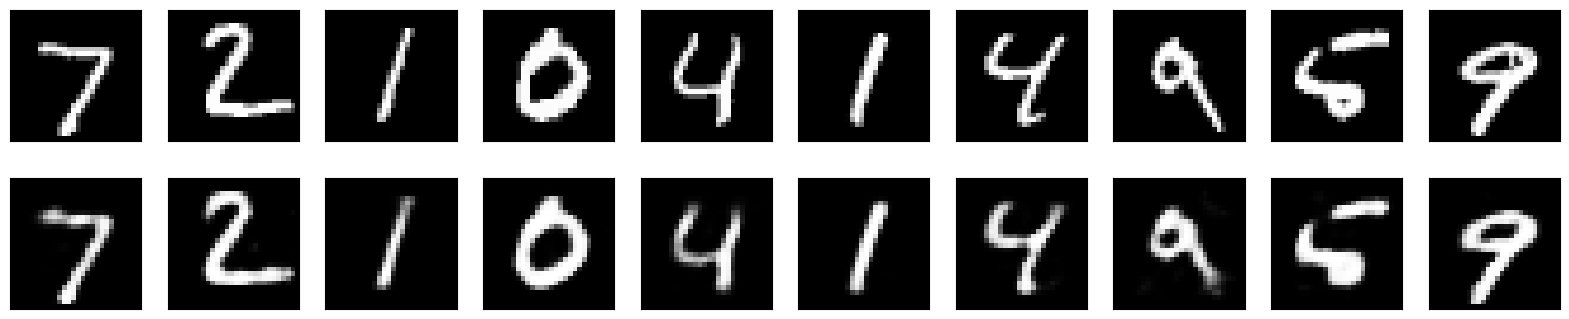

In [2]:
# MNIST训练编码、解码器，包括权重保存、加载功能

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import os
from pathlib import Path

# 创建工作目录
def create_relative_path(folder_path):
    # 将路径中的 ~ 解析为用户的主目录
    expanded_path = os.path.expanduser(folder_path)
    
    # 将路径转换为Path对象，以便跨平台兼容
    path = Path(expanded_path)
    
    # 如果路径不存在，则创建多级目录
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
        print(f"文件夹 '{expanded_path}' 已创建。")
    else:
        print(f"文件夹 '{expanded_path}' 已存在，未进行覆盖。")
    
    # 切换工作目录到新创建的文件夹
    os.chdir(path)
    print(f"当前工作目录已切换到 '{path}'。")

# 示例：创建相对路径文件夹，支持 ~
work_path = "~/ann_test/test4"
create_relative_path(work_path)

# 加载MNIST数据集
(x_train, _), (x_test, _) = mnist.load_data()

# 归一化数据
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# 展平数据
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# 定义参数
input_dim = 784  # 输入维度 (28*28)
encoding_dim_1 = 128  # 第一层编码维度
encoding_dim_2 = 64   # 第二层编码维度

# 构建第一个自编码器
input_layer = Input(shape=(input_dim,))
encoded_1 = Dense(encoding_dim_1, activation='relu')(input_layer)
decoded_1 = Dense(input_dim, activation='sigmoid')(encoded_1)

autoencoder_1 = Model(input_layer, decoded_1)
encoder_1 = Model(input_layer, encoded_1)

autoencoder_1.compile(optimizer=Adam(), loss='binary_crossentropy')

# 训练第一个自编码器
autoencoder_1.fit(x_train, x_train,
                  epochs=50,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(x_test, x_test))

# 保存第一个自编码器的权重
autoencoder_1.save_weights('autoencoder_1.weights.h5')

# 使用第一个自编码器的编码部分作为第二个自编码器的输入
encoded_input_1 = Input(shape=(encoding_dim_1,))

# 构建第二个自编码器
encoded_2 = Dense(encoding_dim_2, activation='relu')(encoded_input_1)
decoded_2 = Dense(encoding_dim_1, activation='relu')(encoded_2)  # 输出应与第一个编码器的输入相同

autoencoder_2 = Model(encoded_input_1, decoded_2)
encoder_2 = Model(encoded_input_1, encoded_2)

autoencoder_2.compile(optimizer=Adam(), loss='binary_crossentropy')

# 提取第一个自编码器的编码输出作为第二个自编码器的输入
encoded_output_1 = encoder_1.predict(x_train)

# 训练第二个自编码器
autoencoder_2.fit(encoded_output_1, encoded_output_1,
                  epochs=50,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(encoder_1.predict(x_test), encoder_1.predict(x_test)))

# 保存第二个自编码器的权重
autoencoder_2.save_weights('autoencoder_2.weights.h5')

# 构建完整的堆叠式自动编码器
encoded_input_full = Input(shape=(input_dim,))
encoded_full_1 = encoder_1(encoded_input_full)
encoded_full_2 = encoder_2(encoded_full_1)
decoder_layer_2 = autoencoder_2.layers[-1]  # 获取第二个自编码器的解码层
decoded_intermediate = decoder_layer_2(encoded_full_2)
decoder_layer_1 = autoencoder_1.layers[-1]  # 获取第一个自编码器的解码层
decoded_full = decoder_layer_1(decoded_intermediate)

stacked_autoencoder = Model(encoded_input_full, decoded_full)
stacked_encoder = Model(encoded_input_full, encoded_full_2)

stacked_autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

# 训练完整的堆叠式自动编码器
stacked_autoencoder.fit(x_train, x_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_test, x_test))

# 保存完整的堆叠式自动编码器的权重
stacked_autoencoder.save_weights('stacked_autoencoder.weights.h5')

# 测试堆叠式自动编码器
decoded_imgs = stacked_autoencoder.predict(x_test)

# 显示一些测试结果
import matplotlib.pyplot as plt

n = 10  # 显示的图像数量
plt.figure(figsize=(20, 4))
for i in range(n):
    # 原始图像
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 解码后的图像
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# 加载权重（如果需要）
autoencoder_1.load_weights('autoencoder_1.weights.h5')
autoencoder_2.load_weights('autoencoder_2.weights.h5')
stacked_autoencoder.load_weights('stacked_autoencoder.weights.h5')


#### 延展-加载上面程序训练后权重的测试程序，64维向量反向解码

文件夹 '/home/renhj/ann_test/test4' 已存在，未进行覆盖。
当前工作目录已切换到 '/home/renhj/ann_test/test4'。
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


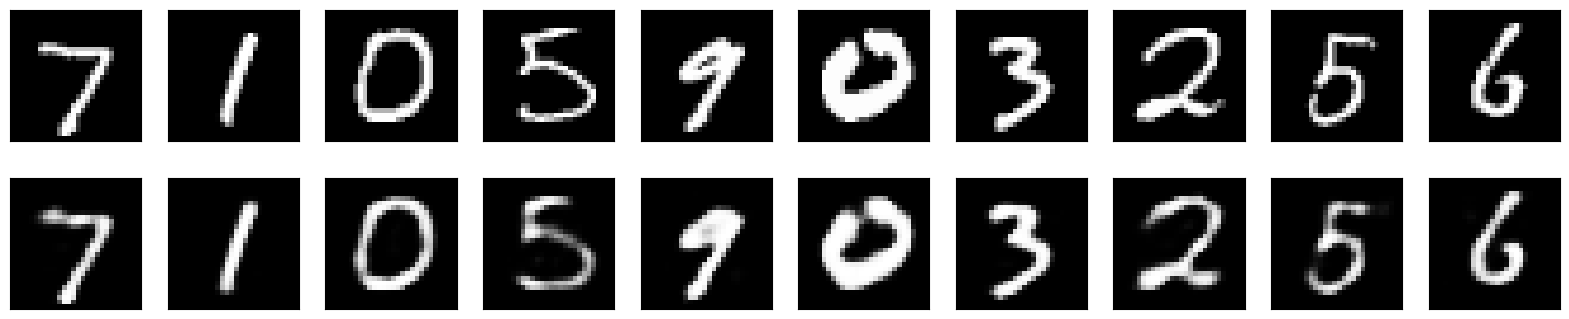

In [3]:
# 加载上面程序训练后权重的测试程序，64维向量反向解码

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import os
from pathlib import Path

# 创建工作目录
def create_relative_path(folder_path):
    # 将路径中的 ~ 解析为用户的主目录
    expanded_path = os.path.expanduser(folder_path)
    
    # 将路径转换为Path对象，以便跨平台兼容
    path = Path(expanded_path)
    
    # 如果路径不存在，则创建多级目录
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
        print(f"文件夹 '{expanded_path}' 已创建。")
    else:
        print(f"文件夹 '{expanded_path}' 已存在，未进行覆盖。")
    
    # 切换工作目录到新创建的文件夹
    os.chdir(path)
    print(f"当前工作目录已切换到 '{path}'。")

# 示例：创建相对路径文件夹，支持 ~
work_path = "~/ann_test/test4"
create_relative_path(work_path)


# 定义参数
input_dim = 784  # 输入维度 (28*28)
encoding_dim_1 = 128  # 第一层编码维度
encoding_dim_2 = 64   # 第二层编码维度

# 构建第一个自编码器
input_layer = Input(shape=(input_dim,))
encoded_1 = Dense(encoding_dim_1, activation='relu')(input_layer)
decoded_1 = Dense(input_dim, activation='sigmoid')(encoded_1)

autoencoder_1 = Model(input_layer, decoded_1)
encoder_1 = Model(input_layer, encoded_1)

# 加载第一个自编码器的权重
autoencoder_1.load_weights('autoencoder_1.weights.h5')

# 使用第一个自编码器的编码部分作为第二个自编码器的输入
encoded_input_1 = Input(shape=(encoding_dim_1,))

# 构建第二个自编码器
encoded_2 = Dense(encoding_dim_2, activation='relu')(encoded_input_1)
decoded_2 = Dense(encoding_dim_1, activation='relu')(encoded_2)  # 输出应与第一个编码器的输入相同

autoencoder_2 = Model(encoded_input_1, decoded_2)
encoder_2 = Model(encoded_input_1, encoded_2)

# 加载第二个自编码器的权重
autoencoder_2.load_weights('autoencoder_2.weights.h5')

# 构建完整的堆叠式自动编码器
encoded_input_full = Input(shape=(input_dim,))
encoded_full_1 = encoder_1(encoded_input_full)
encoded_full_2 = encoder_2(encoded_full_1)
decoder_layer_2 = autoencoder_2.layers[-1]  # 获取第二个自编码器的解码层
decoded_intermediate = decoder_layer_2(encoded_full_2)
decoder_layer_1 = autoencoder_1.layers[-1]  # 获取第一个自编码器的解码层
decoded_full = decoder_layer_1(decoded_intermediate)

stacked_autoencoder = Model(encoded_input_full, decoded_full)
stacked_encoder = Model(encoded_input_full, encoded_full_2)

# 加载完整的堆叠式自动编码器的权重
stacked_autoencoder.load_weights('stacked_autoencoder.weights.h5')

# 加载MNIST数据集
(x_train, _), (x_test, _) = mnist.load_data()

# 归一化数据
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# 展平数据
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# 选择特定的测试样本
selected_indices = [0, 5, 10, 15, 20, 25, 30, 35, 45, 50]  # 可以更改这些索引
custom_test_data = x_test[selected_indices]

# 测试堆叠式自动编码器
decoded_imgs = stacked_autoencoder.predict(custom_test_data)

# 显示一些测试结果
import matplotlib.pyplot as plt

n = len(selected_indices)  # 显示的图像数量
plt.figure(figsize=(20, 4))
for i in range(n):
    # 原始图像
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(custom_test_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 解码后的图像
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


#### Page208 10.2.1 GAN 生成对抗网络

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
文件夹 '/home/renhj/ann_test/test5' 已存在，未进行覆盖。
当前工作目录已切换到 '/home/renhj/ann_test/test5'。
[Epoch 0/100] [Batch 0/938] [D loss: 0.6834, acc: 0.6834] [G loss: 0.6987]
[Epoch 0/100] [Batch 400/938] [D loss: 0.1638, acc: 0.1638] [G loss: 1.7850]
[Epoch 0/100] [Batch 800/938] [D loss: 0.4474, acc: 0.4474] [G loss: 0.8686]
[Epoch 1/100] [Batch 262/938] [D loss: 0.3078, acc: 0.3078] [G loss: 1.3209]
[Epoch 1/100] [Batch 662/938] [D loss: 0.7854, acc: 0.7854] [G loss: 7.9350]
[Epoch 2/100] [Batch 124/938] [D loss: 0.2280, acc: 0.2280] [G loss: 1.9762]
[Epoch 2/100] [Batch 524/938] [D loss: 0.2820, acc: 0.2820] [G loss: 1.4148]
[Epoch 2/100] [Batch 924/938] [D loss: 0.3028, acc: 0.3028] [G loss: 3.4482]
[Epoch 3/100] [Batch 386/938] [D loss: 0.1081, acc: 0.1081] [G loss: 2.6880]
[Epoch 3/100] [Batch 786/938] [D loss: 0.0982, acc: 0.0982] [G loss: 2

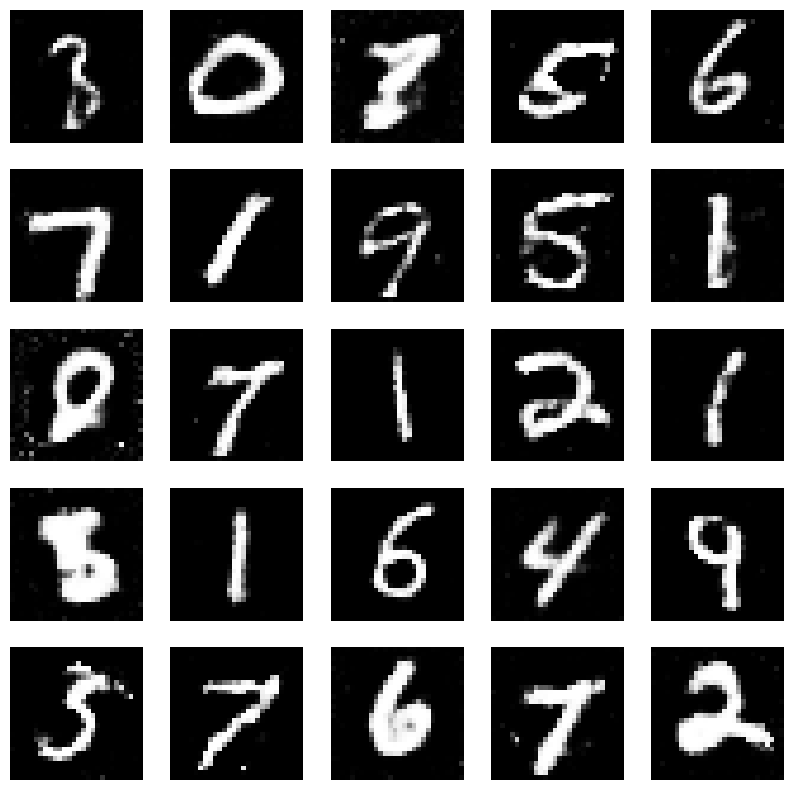

测试完成


In [1]:
# Page208 10.2.1 GAN 生成对抗网络

import os
import torch
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import os
from pathlib import Path

# 创建工作目录
def create_relative_path(folder_path):
    # 将路径中的 ~ 解析为用户的主目录
    expanded_path = os.path.expanduser(folder_path)
    
    # 将路径转换为Path对象，以便跨平台兼容
    path = Path(expanded_path)
    
    # 如果路径不存在，则创建多级目录
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
        print(f"文件夹 '{expanded_path}' 已创建。")
    else:
        print(f"文件夹 '{expanded_path}' 已存在，未进行覆盖。")
    
    # 切换工作目录到新创建的文件夹
    os.chdir(path)
    print(f"当前工作目录已切换到 '{path}'。")

# 示例：创建相对路径文件夹，支持 ~
work_path = "~/ann_test/test5"
create_relative_path(work_path)

# 设置随机种子以保证结果可重复
torch.manual_seed(42)

# 检测是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理和加载
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 定义生成器模型
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

# 定义判别器模型
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity



# 初始化生成器和判别器
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 损失函数和优化器
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 创建目录用于保存图像和模型
os.makedirs('./images', exist_ok=True)
os.makedirs('./saved_models', exist_ok=True)

# 检查模型文件是否存在
generator_path = Path('./saved_models/generator.pth')
discriminator_path = Path('./saved_models/discriminator.pth')

latent_dim = 100

if generator_path.exists() and discriminator_path.exists():
    # 加载已存在的模型权重
    generator.load_state_dict(torch.load(str(generator_path)))
    discriminator.load_state_dict(torch.load(str(discriminator_path)))
    print("模型权重已成功加载")
else:
    # 训练循环
    num_epochs = 100
    #latent_dim = 100

    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(train_loader):
    
            # 将数据移动到设备（CPU或GPU）
            imgs = imgs.to(device)
    
            # Adversarial ground truths
            valid = torch.ones(imgs.size(0), 1).float().to(device)
            fake = torch.zeros(imgs.size(0), 1).float().to(device)
    
            # -----------------
            #  Train Generator
            # -----------------
    
            optimizer_G.zero_grad()
    
            # Sample noise as generator input
            z = torch.randn(imgs.shape[0], latent_dim).to(device)
    
            # Generate a batch of images
            gen_imgs = generator(z)
    
            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)
    
            g_loss.backward()
            optimizer_G.step()
    
            # ---------------------
            #  Train Discriminator
            # ---------------------
    
            optimizer_D.zero_grad()
    
            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
    
            d_loss.backward()
            optimizer_D.step()
    
            batches_done = epoch * len(train_loader) + i
            if batches_done % 400 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                      f"[D loss: {d_loss.item():.4f}, acc: {(real_loss.item() + fake_loss.item()) / 2:.4f}] "
                      f"[G loss: {g_loss.item():.4f}]")
    
                # 保存生成的图像
                save_image(gen_imgs.data[:25], f"images/{batches_done}.png", nrow=5, normalize=True)

    # 保存模型
    torch.save(generator.state_dict(), str(generator_path))
    torch.save(discriminator.state_dict(), str(discriminator_path))
    print("模型已训练完成并保存")

# 测试模型
# 生成一些样本用于可视化
z = torch.randn(25, latent_dim).to(device)
gen_imgs = generator(z)

# 显示最后一批生成的图像
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(gen_imgs[i].detach().cpu().numpy()[0], cmap='gray')
    plt.axis('off')
plt.show()

print("测试完成")

### 10.3 卷积神经网络

#### 延展-CNN卷积神经网络-卷积核运算结果的可视化

文件夹 '/home/renhj/ann_test/test6' 已存在，未进行覆盖。
当前工作目录已切换到 '/home/renhj/ann_test/test6'。


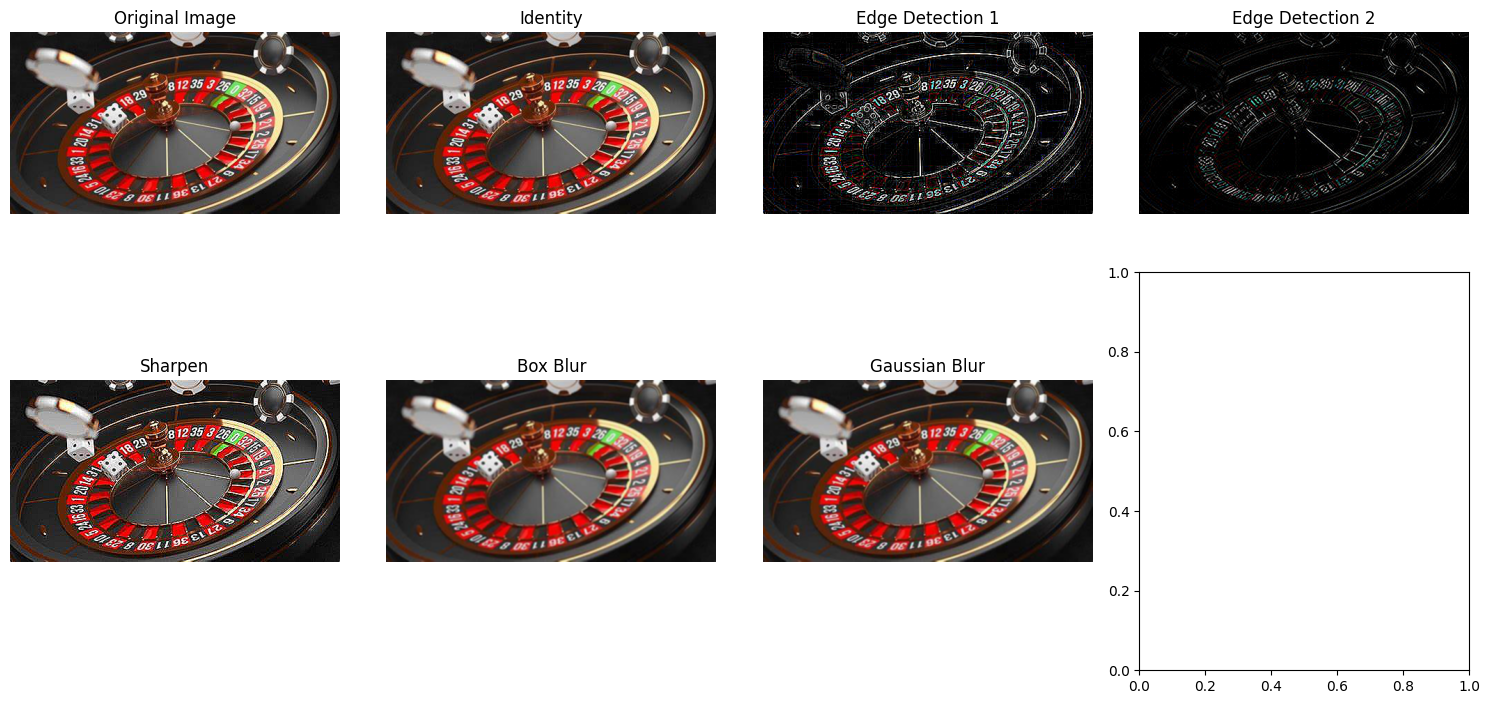

In [6]:
# 卷积核运算结果的可视化
# 请准备一幅jpeg格式图片，放在路径下，修改名字为“OIF-D.jpeg”

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path

# 创建工作目录
def create_relative_path(folder_path):
    # 将路径中的 ~ 解析为用户的主目录
    expanded_path = os.path.expanduser(folder_path)
    
    # 将路径转换为Path对象，以便跨平台兼容
    path = Path(expanded_path)
    
    # 如果路径不存在，则创建多级目录
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
        print(f"文件夹 '{expanded_path}' 已创建。")
    else:
        print(f"文件夹 '{expanded_path}' 已存在，未进行覆盖。")
    
    # 切换工作目录到新创建的文件夹
    os.chdir(path)
    print(f"当前工作目录已切换到 '{path}'。")

# 示例：创建相对路径文件夹，支持 ~
work_path = "~/ann_test/test6"
create_relative_path(work_path)

# 读取图像
image_path = 'OIF-D.jpeg'
image = Image.open(image_path).convert('RGB')
image = np.array(image)

# 定义多种卷积核
kernels = {
    'Identity': np.array([[0, 0, 0],
                          [0, 1, 0],
                          [0, 0, 0]]),
    'Edge Detection 1': np.array([[-1, -1, -1],
                                  [-1, 8, -1],
                                  [-1, -1, -1]]),
    'Edge Detection 2': np.array([[1, 0, -1],
                                  [0, 0, 0],
                                  [-1, 0, 1]]),
    'Sharpen': np.array([[0, -1, 0],
                         [-1, 5, -1],
                         [0, -1, 0]]),
    'Box Blur': np.array([[1, 1, 1],
                          [1, 1, 1],
                          [1, 1, 1]]) / 9,
    'Gaussian Blur': np.array([[1, 2, 1],
                               [2, 4, 2],
                               [1, 2, 1]]) / 16
}

# 定义卷积函数
def apply_convolution(image, kernel):
    k_size = kernel.shape[0]
    pad_size = k_size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')
    convolved_image = np.zeros_like(image, dtype=np.float32)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for c in range(image.shape[2]):
                convolved_image[i, j, c] = np.sum(padded_image[i:i+k_size, j:j+k_size, c] * kernel)
    
    # 确保像素值在0-255范围内
    convolved_image = np.clip(convolved_image, 0, 255).astype(np.uint8)
    
    return convolved_image

# 应用卷积核并存储结果
convolved_images = {}
for name, kernel in kernels.items():
    convolved_image = apply_convolution(image, kernel)
    convolved_images[name] = convolved_image

# 可视化显示原始图像和卷积后的图像
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes[0, 0].imshow(image)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

for i, (name, convolved_image) in enumerate(convolved_images.items()):
    row = (i + 1) // 4
    col = (i + 1) % 4
    axes[row, col].imshow(convolved_image)
    axes[row, col].set_title(name)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

#### 书中代码-Page217 10.3.4

In [7]:
from keras.datasets import fashion_mnist
(train_X,train_Y),(test_X,test_Y)=fashion_mnist.load_data()

import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt

print('Training data shape :',train_X.shape,train_Y.shape)
print('Testing data shape :',test_X.shape,test_Y.shape)

classes=np.unique(train_Y)
nClasses=len(classes)
print('Total number of outputs :',nClasses)
print('Output classes :',classes)

train_X=train_X.reshape(-1,28,28,1)
test_X=test_X.reshape(-1,28,28,1)
train_X=train_X.astype('float32')
test_X=test_X.astype('float32')
train_X=train_X/255
test_X=test_X/255

train_Y_one_hot=to_categorical(train_Y)
test_Y_one_hot=to_categorical(test_Y)
print('Original label:',train_Y[0])
print('After conversion to one-hot:',train_Y_one_hot[0])

from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label= train_test_split(train_X,train_Y_one_hot,test_size=0.2,random_state=13)

文件夹 '/home/renhj/ann_test/test7' 已创建。
当前工作目录已切换到 '/home/renhj/ann_test/test7'。
Training data shape : (60000, 28, 28) (60000,)
Testing data shape : (10000, 28, 28) (10000,)
Total number of outputs : 10
Output classes : [0 1 2 3 4 5 6 7 8 9]
Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


#### 书中代码-Page217

In [8]:
# 书中代码-Page217 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils import to_categorical
from keras.datasets import fashion_mnist

# 参数设置
batch_size = 64
epochs = 20
num_classes = 10  # Fashion MNIST 有 10 个类别

# 加载 Fashion MNIST 数据集
(train_X, train_label), (test_X, test_label) = fashion_mnist.load_data()

# 数据预处理
# 将图像数据归一化到 [0, 1]
train_X = train_X.astype('float32') / 255
test_X = test_X.astype('float32') / 255

# 将图像数据调整为 (28, 28, 1) 的形状
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)

# 将标签转换为 one-hot 编码
train_label = to_categorical(train_label, num_classes)
test_label = to_categorical(test_label, num_classes)

# 划分训练集和验证集
valid_X = train_X[:5000]
valid_label = train_label[:5000]
train_X = train_X[5000:]
train_label = train_label[5000:]

# 构建模型
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', input_shape=(28, 28, 1), padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear', padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(Dense(num_classes, activation='softmax'))

# 编译模型
fashion_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy'])

# 打印模型结构
fashion_model.summary()

# 训练模型
fashion_train = fashion_model.fit(train_X, train_label,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=1,
                                  validation_data=(valid_X, valid_label))

# 评估模型
test_eval = fashion_model.evaluate(test_X, test_label, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

文件夹 '/home/renhj/ann_test/test7' 已存在，未进行覆盖。
当前工作目录已切换到 '/home/renhj/ann_test/test7'。


/home/renhj/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renhj/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,234 (1.36 MB)

 Trainable params: 356,234 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.7697 - loss: 0.6410 - val_accuracy: 0.8890 - val_loss: 0.3061
Epoch 2/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.8976 - loss: 0.2823 - val_accuracy: 0.9096 - val_loss: 0.2428
Epoch 3/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9167 - loss: 0.2254 - val_accuracy: 0.9168 - val_loss: 0.2294
Epoch 4/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9288 - loss: 0.1956 - val_accuracy: 0.9174 - val_loss: 0.2199
Epoch 5/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9374 - loss: 0.1693 - val_accuracy: 0.9246 - val_loss: 0.2038
Epoch 6/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9481 - loss: 0.1434 - val_accuracy: 0.9222 - val_loss: 0.2265
Epoch 7/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9532 - loss: 0.1237 - val_accuracy: 0.9276 - val_loss: 0.2175
Epoch 8/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9617 - loss: 0.1028 - 

#### Page221 10.3.5 LeNet-5卷积网络处理MNIST数据集

文件夹 '/home/renhj/ann_test/test7' 已存在，未进行覆盖。
当前工作目录已切换到 '/home/renhj/ann_test/test7'。
Epoch 1/10, Loss: 0.25730017179063264
Epoch 2/10, Loss: 0.07345538855548193
Epoch 3/10, Loss: 0.05108486504595814
Epoch 4/10, Loss: 0.039055618611640974
Epoch 5/10, Loss: 0.031189450338646185
Epoch 6/10, Loss: 0.02694226090622786
Epoch 7/10, Loss: 0.022269084235994087
Epoch 8/10, Loss: 0.019111752896937655
Epoch 9/10, Loss: 0.017764007391123625
Epoch 10/10, Loss: 0.013095082014753569


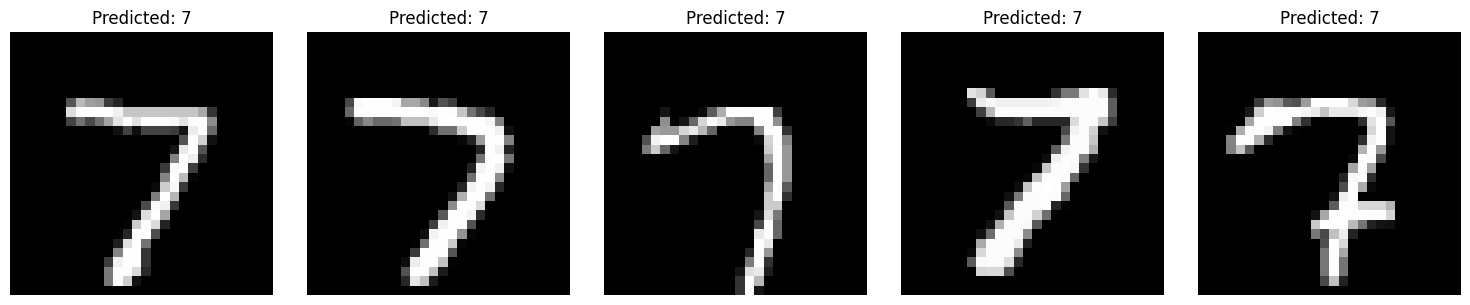

In [2]:
### 1. 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

# 创建工作目录
def create_relative_path(folder_path):
    # 将路径中的 ~ 解析为用户的主目录
    expanded_path = os.path.expanduser(folder_path)
    
    # 将路径转换为Path对象，以便跨平台兼容
    path = Path(expanded_path)
    
    # 如果路径不存在，则创建多级目录
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
        print(f"文件夹 '{expanded_path}' 已创建。")
    else:
        print(f"文件夹 '{expanded_path}' 已存在，未进行覆盖。")
    
    # 切换工作目录到新创建的文件夹
    os.chdir(path)
    print(f"当前工作目录已切换到 '{path}'。")

# 示例：创建相对路径文件夹，支持 ~
work_path = "~/ann_test/test7"
create_relative_path(work_path)


### 2. 定义 LeNet-5 模型
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2), # padding to keep size
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0), # no padding here
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0), # no padding here
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120 * 1 * 1, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=num_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)  # Flatten the tensor for the classifier
        logits = self.classifier(x)
        return logits  # Return logits instead of probabilities for training

### 3. 加载 MNIST 数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 4. 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 5. 训练模型
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)  # 修改这里
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss/len(train_loader)}")


### 6. 测试模型并可视化数字 '7'
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 在测试集中找到所有标签为7的样本索引
seven_indices = [i for i, label in enumerate(test_dataset.targets) if label == 7]

# 取前几个数字7进行预测和可视化
num_samples_to_show = 5
seven_samples = [(test_dataset[i][0], test_dataset[i][1]) for i in seven_indices[:num_samples_to_show]]

model.eval()
fig, axes = plt.subplots(1, num_samples_to_show, figsize=(15, 3))
with torch.no_grad():
    for ax, (image, label) in zip(axes, seven_samples):
        original_image = image  # 保存原始图像
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        output = model(image)
        _, predicted = torch.max(output, 1)
        ax.imshow(original_image.cpu().squeeze(), cmap='gray')  # 使用原始图像进行可视化
        ax.set_title(f'Predicted: {predicted.item()}')
        ax.axis('off')

plt.tight_layout()
plt.show()

### 10.4 生成对抗网络

#### 书中代码-Page225 10.4.4

In [3]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
class ImageHelper(object):
    def save_image(self,generated,epoch,directory):
    def makegif(self,directory):

from __future__ import print_function,division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input,Dense,Reshape,Flatten,BatchNormalization,LeakyReLU
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam

class GAN():
    def __init__(self,image_shape,generator_input_dim,image_hepler):
        optimizer=Adam(0.0002,0.5)
        self._image_helper=image_hepler
        self.img_shape=image_shape
        self.generator_input_dim=generator_input_dim
        self._build_generator_model()
        self._build_and_compile_discriminator_model(optimizer)
        self._build_and_compile_gen(optimizer)

    def train():
        real=np.ones((batch_size,1))
        fake=np.zeros((batch_size,1))
        history=[]
        for epoch in range(epochs):
            batch_indexes=np.random.randint(0,train_data.shape[0],batch_size)
            batch=train_data[batch_indexes]
            genenerated=self._predict_noise(batch_size)
            loss_real=self.discriminator_model.train_on_batch(batch,real)
            loss_fake=self.discriminator_model.train_on_batch(genenerated,fake)
            discriminator_loss=0.5*np.add(loss_real,loss_fake)
            noise=np.random.normal(0,1,(batch_size,self.generator_input_dim))
            generator_loss=self.gan.train_on_batch(noise,real)
        self._plot_loss(history)
        self._image_helper.makegif("generated/")
        
    def _build_generator_model(self):
        generator_input=Input(shape=(self.generator_input_dim,))
        generator_seqence=Sequential(
            [Dense()256,input_dim=self.generator_input_dim,
             LeakyReLU(aplpha=0.2),
             BatchNormalization(momentum=0.8),
             Dense(512),
             LeakyReLU(alpha=0.2),
             BatchNormalization(momentum=0.8),
             Dense(1024),
             LeakyReLU(alpha=0.2),
             BatchNormalization(momentum=0.8),
             Dense(np.prod(self.img_shape),activation='train'),
             Reshape(self.img_shape)
             
            ]
            
        )
        generator_output_tensor=generator_seqence(generator_input)
        self.generator_model=Model(generator_input,generator_outpyt_tensor)

        
    def _build_and_compile_discriminator_model(self,optimizer):
        discriminator_input=Input(shape=self.img_shape)
        discriminator_sequence=Sequential(
            [Flatten(input_shape=self.img_shape),
             Dense(52),
             LeakyReLU(aplpha=0.2),
             Dense(256),
             LeakyReLU(aplpha=0.2),
             Dense(1,activation='sigmoid')
                
            ]
        )
        discriminator_tensor=discriminator_sequence(discriminator_input)
        self.discriminaotr_model=Model(discriminator_input,discriminator_tensor)
        self.discriminator_model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
        self.discriminator_model.trainable=Flase

        
    def _build_and_compile_gen(self,optimizer):
        real_input=Input(shape=(self.generator_input_dim,))
        generator_output=self.generator_model(real_input)
        discriminator_outpu=self.discriminator_model(generator_output)
        self.gan=Model(real_input,discriminaotr_output)
        self.gen.compile(loss='binary_crossentropy',optimizer=optimizer)
        
    def _save_images(self,epoch):
        generated=self._predict_noise(25)
        generated=0.5*generated+0.5
        self._image_helper.save_image(generated,epoch,"generated/")
        
    def _predict_noise(self,size):
        noise=np.random.normal(0,1,(size,self.generator_input_dim))
        return self.generator_model.predict(noise)
        
    def _plot_loss(self,history):
        hist=pd.DataFrame(history)
        plt.figure(figsize=(20,5))
        for coinm in hist.columns:
            plt.plot(hist[colnm],label=colnm)
        plt.legend()
        plt.ylabel("loss")
        plt.xlabel("epochs")
        plt.show()


import numpy as np
from keras.datasets import fashion_mnist
(X,_),(_,_)=fashion_mnist.load_data()
X_train=X/127.5-1.
X_train=np.expand_dims(X_train,axis=3)
image_helper=ImageHelper()
generative_advarsial_network=GAN(X_train[0].shape,100,image_helper)
generative_advarsial_network.train(30000,X_train,batch_size=32)
plt.show()


IndentationError: expected an indented block after function definition on line 6 (323351830.py, line 7)

#### 补充后代码

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


/home/renhj/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renhj/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/renhj/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/renhj/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warni

0 [D loss: 0.6610605120658875 | Acc.: 71.875] [G loss: 0.6423700451850891]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━

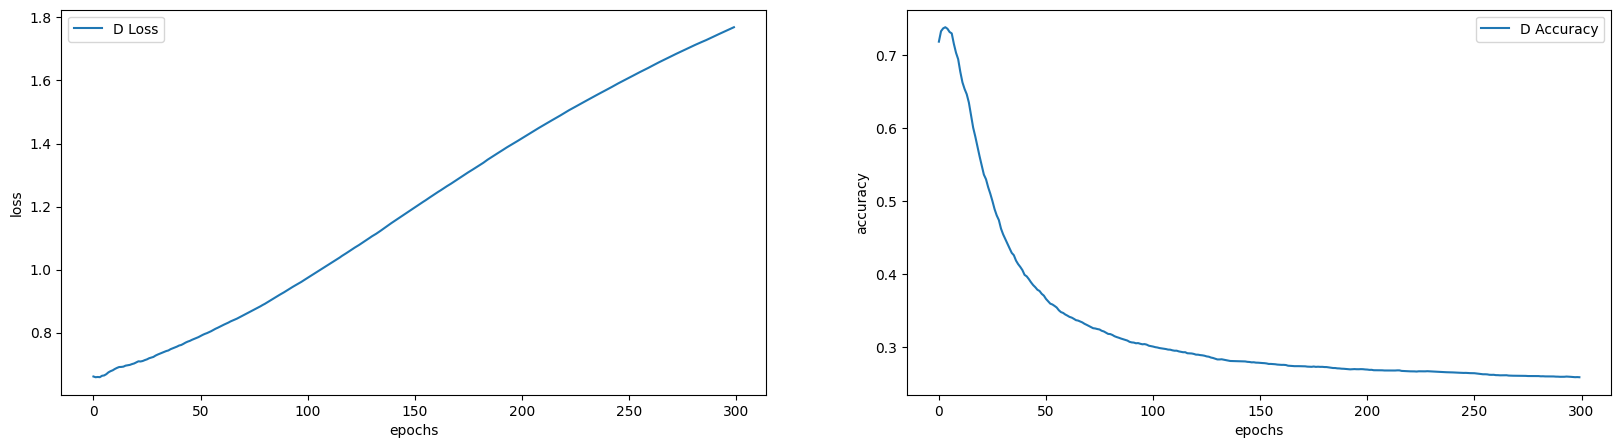

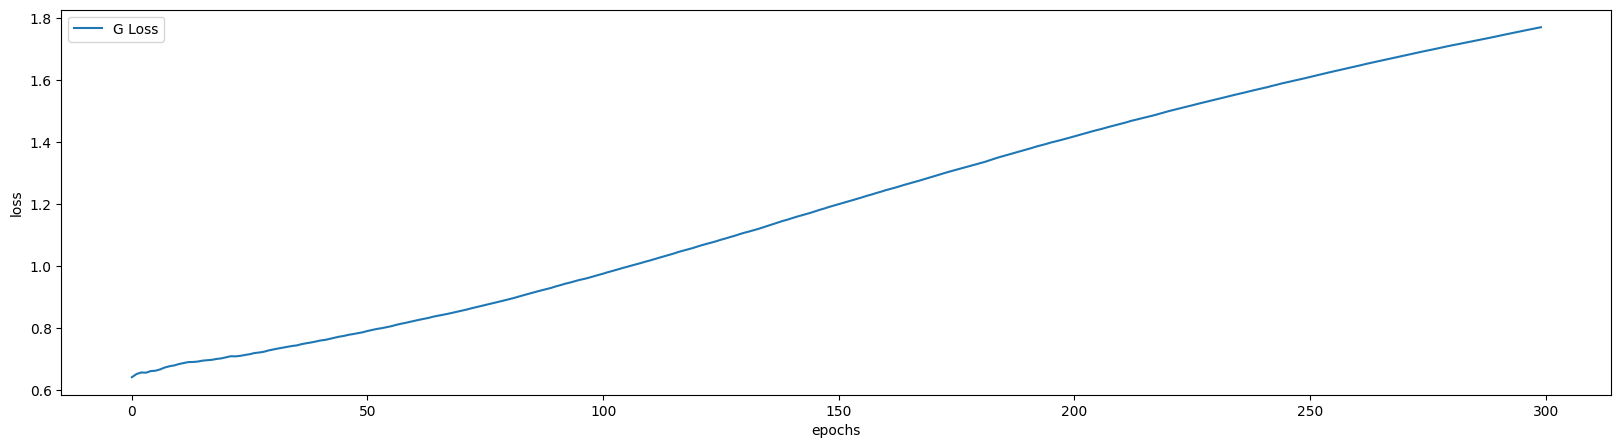

/tmp/ipykernel_9119/2546002046.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(directory, img))


In [6]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

class ImageHelper:
    def save_image(self, generated, epoch, directory):
        """Save generated images in a grid."""
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig, axs = plt.subplots(5, 5)
        cnt = 0
        for i in range(5):
            for j in range(5):
                axs[i, j].imshow(generated[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(f"{directory}/epoch_{epoch}.png")
        plt.close()

    def makegif(self, directory):
        """Create a GIF from saved images."""
        images = [imageio.imread(os.path.join(directory, img)) 
                  for img in sorted(os.listdir(directory)) if img.endswith('.png')]
        imageio.mimsave(f'{directory}/training.gif', images)

class GAN:
    def __init__(self, image_shape, generator_input_dim):
        self.img_shape = image_shape
        self.generator_input_dim = generator_input_dim
        self._image_helper = ImageHelper()
        optimizer = Adam(0.0002, 0.5)
        
        # Build and compile models
        self.generator_model = self._build_generator_model()
        self.discriminator_model = self._build_and_compile_discriminator_model(optimizer)
        self.gan = self._build_and_compile_gan(optimizer)

    def train(self, epochs, train_data, batch_size):
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        history = []
    
        for epoch in range(epochs):
            # Train Discriminator
            idx = np.random.randint(0, train_data.shape[0], batch_size)
            batch = train_data[idx]
            noise = np.random.normal(0, 1, (batch_size, self.generator_input_dim))
            generated_images = self.generator_model.predict(noise)
    
            d_loss_real = self.discriminator_model.train_on_batch(batch, real)
            d_loss_fake = self.discriminator_model.train_on_batch(generated_images, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, self.generator_input_dim))
            g_loss = self.gan.train_on_batch(noise, real)
    
            # Ensure g_loss is a scalar
            if isinstance(g_loss, (list, np.ndarray)):
                g_loss = g_loss[0]  # Take the first element if g_loss is a list/array
    
            # Store history
            history.append({'d_loss': d_loss[0], 'd_acc': d_loss[1], 'g_loss': g_loss})
    
            # Save generated images at intervals
            if epoch % 100 == 0:
                print(f"{epoch} [D loss: {d_loss[0]} | Acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")
                self._save_images(epoch)
    
        self._plot_loss(history)
        self._image_helper.makegif("generated/")

    def _build_generator_model(self):
        model = Sequential([
            Dense(256, input_dim=self.generator_input_dim),
            LeakyReLU(alpha=0.2),
            BatchNormalization(),
            Dense(512),
            LeakyReLU(alpha=0.2),
            BatchNormalization(),
            Dense(1024),
            LeakyReLU(alpha=0.2),
            BatchNormalization(),
            Dense(np.prod(self.img_shape), activation='tanh'),
            Reshape(self.img_shape)
        ])
        return model

    def _build_and_compile_discriminator_model(self, optimizer):
        model = Sequential([
            Flatten(input_shape=self.img_shape),
            Dense(512),
            LeakyReLU(alpha=0.2),
            Dense(256),
            LeakyReLU(alpha=0.2),
            Dense(1, activation='sigmoid')
        ])
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

    def _build_and_compile_gan(self, optimizer):
        self.discriminator_model.trainable = False
        gan_input = Input(shape=(self.generator_input_dim,))
        generated_img = self.generator_model(gan_input)
        gan_output = self.discriminator_model(generated_img)
        gan = Model(gan_input, gan_output)
        gan.compile(loss='binary_crossentropy', optimizer=optimizer)
        return gan

    def _save_images(self, epoch):
        generated = self._predict_noise(25)
        generated = 0.5 * generated + 0.5  # Scale images to [0, 1]
        self._image_helper.save_image(generated, epoch, "generated/")

    def _predict_noise(self, size):
        noise = np.random.normal(0, 1, (size, self.generator_input_dim))
        return self.generator_model.predict(noise)

    def _plot_loss(self, history):
        hist = pd.DataFrame(history)
        plt.figure(figsize=(20, 5))
        
        # Plot discriminator loss and accuracy
        plt.subplot(1, 2, 1)
        plt.plot(hist['d_loss'], label='D Loss')
        plt.legend()
        plt.ylabel("loss")
        plt.xlabel("epochs")
        
        plt.subplot(1, 2, 2)
        plt.plot(hist['d_acc'], label='D Accuracy')
        plt.legend()
        plt.ylabel("accuracy")
        plt.xlabel("epochs")
        
        # Plot generator loss
        plt.figure(figsize=(20, 5))
        plt.plot(hist['g_loss'], label='G Loss')
        plt.legend()
        plt.ylabel("loss")
        plt.xlabel("epochs")
        
        plt.show()

# Load the dataset
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train / 127.5 - 1.  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=3)

# Initialize and train the GAN
gan = GAN(image_shape=X_train.shape[1:], generator_input_dim=100)
gan.train(epochs=300, train_data=X_train, batch_size=32)